<a href="https://colab.research.google.com/github/isaacangyu/first-contributions/blob/master/AudioHackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

##Librosa Beat Isolation

In [ ]:
!pip install librosa

In [ ]:
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [ ]:
filename1 = '/content/drive/MyDrive/AudioHackathon/heyjude.mp3'
data1,sample_rate1 = librosa.load(filename1, sr=22050, mono=True, offset=0.0, duration=50, res_type='kaiser_best')

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


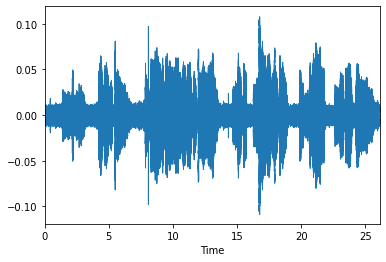

In [ ]:
librosa.display.waveplot(data1,sr=sample_rate1, max_points=50)

In [ ]:
FRAME_SIZE = 2048
HOP_SIZE = 512

In [ ]:
S_scale = librosa.stft(data1, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)

In [ ]:
S_scale.shape

(1025, 1124)

In [ ]:
type(S_scale[0][0])

numpy.complex64

In [ ]:
Y_scale = np.abs(stft) ** 2

In [ ]:
Y_scale.shape

(1025, 1124)

In [ ]:
type(Y_scale[0][0])

numpy.float32

In [ ]:
plt.figure(figsize=(25,10))

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

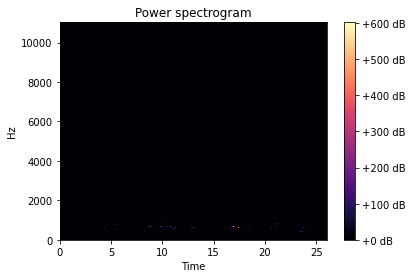

In [ ]:
fig, ax = plt.subplots()
img = librosa.display.specshow(Y_scale, sr=22050, hop_length=HOP_SIZE, x_axis='time', y_axis='linear')
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

In [ ]:
freqs = librosa.fft_frequencies(sr=22050, n_fft=256)

##Get frequency from each FFT

##Pydub frequency and note isolation

###Note isolation

In [ ]:
!pip install pydub

In [ ]:
#from pydub import AudioSegment
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
song = AudioSegment.from_file("/content/drive/MyDrive/AudioHackathon/heyjude.mp3")
# Size of segments to break song into for volume calculations
SEGMENT_MS = 50
# dBFS is decibels relative to the maximum possible loudness
volume = [segment.dBFS for segment in song[::SEGMENT_MS]]

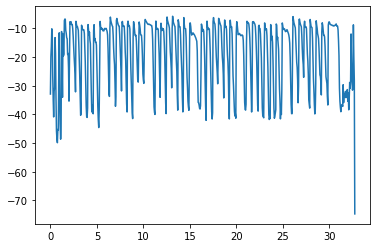

In [ ]:
x_axis = np.arange(len(volume)) * (SEGMENT_MS / 1000)
plt.plot(x_axis, volume)
plt.show()

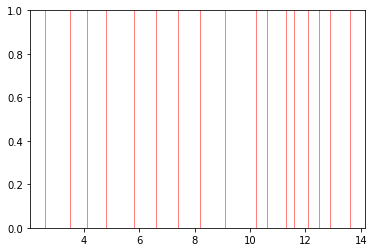

In [ ]:
actual_notes = [2.6, 3.5, 4.1, 4.8, 5.8, 6.6, 7.4, 8.2, 9.1, 10.2, 10.6, 11.3, 11.6, 12.1, 12.5, 12.9, 13.6] #23 notes
for s in actual_notes:
    plt.axvline(x=s, color='r', linewidth=0.5, linestyle="-")

In [ ]:
# Minimum frequency
song = song.high_pass_filter(80) #order parameter?

In [ ]:
# Minimum volume
VOLUME_THRESHOLD = -35

# Throw out any additional notes found in this window
#MIN_MS_BETWEEN = 100

# Minimum increase from previous note
EDGE_THRESHOLD = 5

predicted_starts = []

In [ ]:
for i in range(1, len(volume)):
  if (volume[i] > VOLUME_THRESHOLD and volume[i] - volume[i - 1] > EDGE_THRESHOLD):
    ms = i * SEGMENT_MS
    """
    # Ignore any too close together
    if (
      len(predicted_starts) == 0 or
      ms - predicted_starts[-1] >= MIN_MS_BETWEEN
    ):
    """
    predicted_starts.append(ms)

In [ ]:
len(predicted_starts) #miliseconds

73

###Note conversion

In [ ]:
from collections import Counter
import array
import numpy as np
import scipy
from pydub.utils import get_array_type

In [ ]:
NOTES = {
    "A": 440,
    "A#": 466.1637615180899,
    "B": 493.8833012561241,
    "C": 523.2511306011972,
    "C#": 554.3652619537442,
    "D": 587.3295358348151,
    "D#": 622.2539674441618,
    "E": 659.2551138257398,
    "F": 698.4564628660078,
    "F#": 739.9888454232688,
    "G": 783.9908719634985,
    "G#": 830.6093951598903,
}

In [ ]:
def frequency_spectrum(sample, max_frequency=800):
    bit_depth = sample.sample_width * 8
    array_type = get_array_type(bit_depth)
    raw_audio_data = array.array(array_type, sample._data)
    n = len(raw_audio_data)
    freq_array = np.arange(n) * (float(sample.frame_rate) / n)  # two sides frequency range
    freq_array = freq_array[:(n // 2)]  # one side frequency range
    raw_audio_data = raw_audio_data - np.average(raw_audio_data)  # zero-centering
    
    freq_magnitude = scipy.fft(raw_audio_data) # fft computing and normalization
    freq_magnitude = freq_magnitude[:(n // 2)] # one side
    if max_frequency:
        max_index = int(max_frequency * n / sample.frame_rate) + 1
        freq_array = freq_array[:max_index]
        freq_magnitude = freq_magnitude[:max_index]
    freq_magnitude = abs(freq_magnitude)
    freq_magnitude = freq_magnitude / np.sum(freq_magnitude)
    return freq_array, freq_magnitude

In [ ]:
freq_array, freq_magnitude = frequency_spectrum(song)

In [ ]:
freq_array

array([0.00000000e+00, 2.27143493e-02, 4.54286986e-02, ...,
       7.99953953e+02, 7.99976668e+02, 7.99999382e+02])

In [ ]:
freq_magnitude

array([3.42370815e-19, 5.28273675e-08, 4.83362289e-08, ...,
       5.51696204e-06, 6.73053370e-06, 3.40256288e-06])

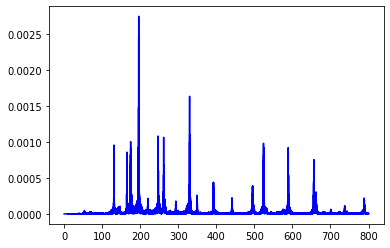

In [ ]:
freq_magnitudes = plt.plot(freq_array, freq_magnitude, 'b') #'b' is blue

Find peaks

In [ ]:
peak_indicies, props = scipy.signal.find_peaks(freq_magnitudes, height=0.015)
for i, peak in enumerate(peak_indicies):
    freq = freq_array[peak]
    magnitude = props["peak_heights"][i]
    print(freq, "hz with magnitude", magnitude)

TypeError: ignored

##Librosa Frequency to MIDI Notes

##Librosa MIDI Notes to Piano Playing

##Code for later

In [ ]:
tempo, beat_times = librosa.beat.beat_track(data1, sr=sample_rate1, start_bpm=120.0, units='time')

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


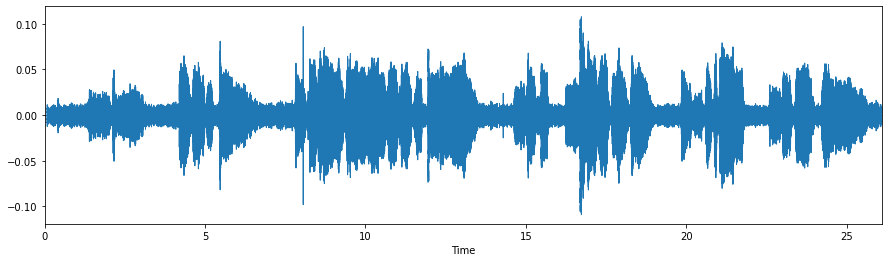

In [ ]:
plt.figure(figsize=(15,4))
librosa.display.waveplot(data1,sr=sample_rate1, max_points=50000.0, x_axis='time', offset=0.0, max_sr=1000)